# LSTM Model for Text Classification
Train the previous LSTM model with 1 million headlines news across 5,000 stocks     
Headlines are the features and stocks' performance are labels  
Use binary labels instead of categorical labels, 0 for negative and 1 for positive performance of daily closing prices

## Training on the cloud
Model was trained on the cloud using Google's Colab

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

Upload data to Colab

Data from Kaggle 'https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests?select=analyst_ratings_processed.csv' which was processed
 


In [2]:
from google.colab import files

uploaded = files.upload()

Saving headlines_labeled.csv to headlines_labeled.csv


In [4]:
df = pd.read_csv('headlines_labeled.csv')

headlines = df.title.values
labels = df.label.values

# Model requirements

vocab_size = 1000 #Vocabulary size
embedding_dim = 16 #Number of dimension of word embedding
max_length = 100 #Max length of sequence, headline should not be longer then 100 words
trunc_type = 'post' #Cut off after max length
padding_type = 'post' #Pad sequence at the end to fill max length
oov_tok = "<OOV>" #replace word that are not in vocabulary with out of vocab token 
training_size = int(len(df)*0.8) #splits data 80% for testing and 20% for validation

#Split training and testing data
train_hl, test_hl, train_l, test_l = train_test_split(headlines, labels, test_size=0.2, random_state=42)

# Tokenizing words, assigning values to most common words and out of vocab words with "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_hl)

word_index = tokenizer.word_index

train_seq = tokenizer.texts_to_sequences(train_hl)
train_pad = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_seq = tokenizer.texts_to_sequences(test_hl)
test_pad = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

LSTM Model

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(62, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') #2 categories bases off stock performance, negative or positive
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#convert tokenizered words into numpy array
train_pad = np.array(train_pad)
train_l = np.array(train_l)
test_pad = np.array(test_pad)
test_l = np.array(test_l)

Train 50 epochs, roughly 8 minutes per epoch  
Save best model, using checkpoints callback

In [6]:
epochs = 50

checkpoint_callback = [ModelCheckpoint(filepath="NLP_BiLSTM_model.hdf5", monitor='accuracy', save_best_only=True, mode='max')]
history = model.fit(train_pad, train_l, epochs=epochs, batch_size=29, callbacks=checkpoint_callback, verbose=1)

model.save('NLP_BiLSTM_model.h5')

Epoch 1/50
27836/27836 [==============================] - 553s 20ms/step - loss: 0.6499 - accuracy: 0.5852
Epoch 2/50
27836/27836 [==============================] - 541s 19ms/step - loss: 0.6382 - accuracy: 0.5985
Epoch 3/50
27836/27836 [==============================] - 539s 19ms/step - loss: 0.6348 - accuracy: 0.6008
Epoch 4/50
27836/27836 [==============================] - 538s 19ms/step - loss: 0.6340 - accuracy: 0.6016
Epoch 5/50
27836/27836 [==============================] - 544s 20ms/step - loss: 0.6324 - accuracy: 0.6047
Epoch 6/50
27836/27836 [==============================] - 543s 19ms/step - loss: 0.6315 - accuracy: 0.6049
Epoch 7/50
27836/27836 [==============================] - 536s 19ms/step - loss: 0.6296 - accuracy: 0.6089
Epoch 8/50
27836/27836 [==============================] - 534s 19ms/step - loss: 0.6282 - accuracy: 0.6111
Epoch 9/50
27836/27836 [==============================] - 535s 19ms/step - loss: 0.6269 - accuracy: 0.6126
Epoch 10/50
27836/27836 [============

Test model on unseen headlines

In [7]:
pred = model.predict(test_pad)
pred_test = pred.flatten().tolist()

result = pd.DataFrame(data={'headllines' : test_hl, 'labels' : test_l, 'predicted' : pred_test})

result['predicted'] = np.where(d['predicted'] < 0.5, 0, 1) #Convert predicted values to 0 and 1, 0 for negative and 1 for positive headlines

result['val'] = np.where(result['labels'] == result['predicted'], 1, 0) #Map correct predictions to labels

result['results'] = result['val'].value_counts(normalize=True)

result.to_csv('predict_headlines.csv')

Amount of negative and positive headlines are balanced

In [13]:
result['labels'].value_counts()

1    105995
0     95817
Name: labels, dtype: int64

Model's accuracy was 60% when tested on unseen data

In [14]:
print(d['val'].value_counts(normalize=True)) 

1    0.602635
0    0.397365
Name: val, dtype: float64


# Visualising Training

Training accuracy peaked at 40 epochs while loss was creeping up after 40 epochs

<function matplotlib.pyplot.show>

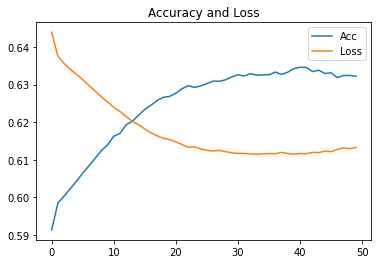

In [15]:
epoch = range(len(history.history['accuracy']))
loss = history.history['loss']
acc = history.history['accuracy']

plt.plot(epoch, acc)
plt.plot(epoch, loss)
plt.title('Accuracy and Loss')
plt.legend(['Acc', 'Loss'])
plt.show

# Conclusion
Training with more data, the same model was able to learn and make better predictions compared to using the limited data from scraping news outlets  
Model was able to learn from headline news across 5,000 stocks, increasing its usefulness

With proper risk and money management, 60% accuracy could lead to profitable trades over long periods
## Next step
Training on bigger model, example "BERT" (limited by current setup, 1 epoch of training on BERT takes 24 hours while Google Colab hard timeout at 12 hours)

**Deploying model**
* Scrape current headlines news to feed into model for predictions
* Add risk and money management features